# Bayesian Structural Time Series: Signal Decomposition

This example shows how Bayesian Structural Time Series (BSTS) can be used to decompose and interpret time series in enterprise applications. 이 예제에서는 수요 예측 문제를 다룬다.  

## Data
This notebook generates synthetic data internally, no external datset are used.

---

## Step 1: Generate Data Sample

We start with generating a sample time series that is comprised of several components that represent some common effects in real demand data:
* **Trend.** We use a linear trend.
* **Seasonality.** We use sine wave to simulate seasonal changes. 
* **Covariates.** Demand normally depends on product price and other known (observed) factors, so we  admix two price-like series of different magnitudes. We will assume that these two series are prices on two related (substitutable or complimentary) products.
* **Covariates with memory effects.** Some factors can have long-lasting effects that are not observed directly. For instance, deep price discounts on consumable goods can make consumers to stockpile these products, and consume less when the price returns to normal levels. One needs to account for this effect (known as the pull-forward effect) to measure the true promotion effectiveness correctly. We simulate it through admixing a smoothed and delayed covariate. Note that we observe the original covariate (e.g. product's own price), but not its smoothed version. Consequently, the goal of decomposition is to reconstruct this unobserved smoothed and delayed version.   

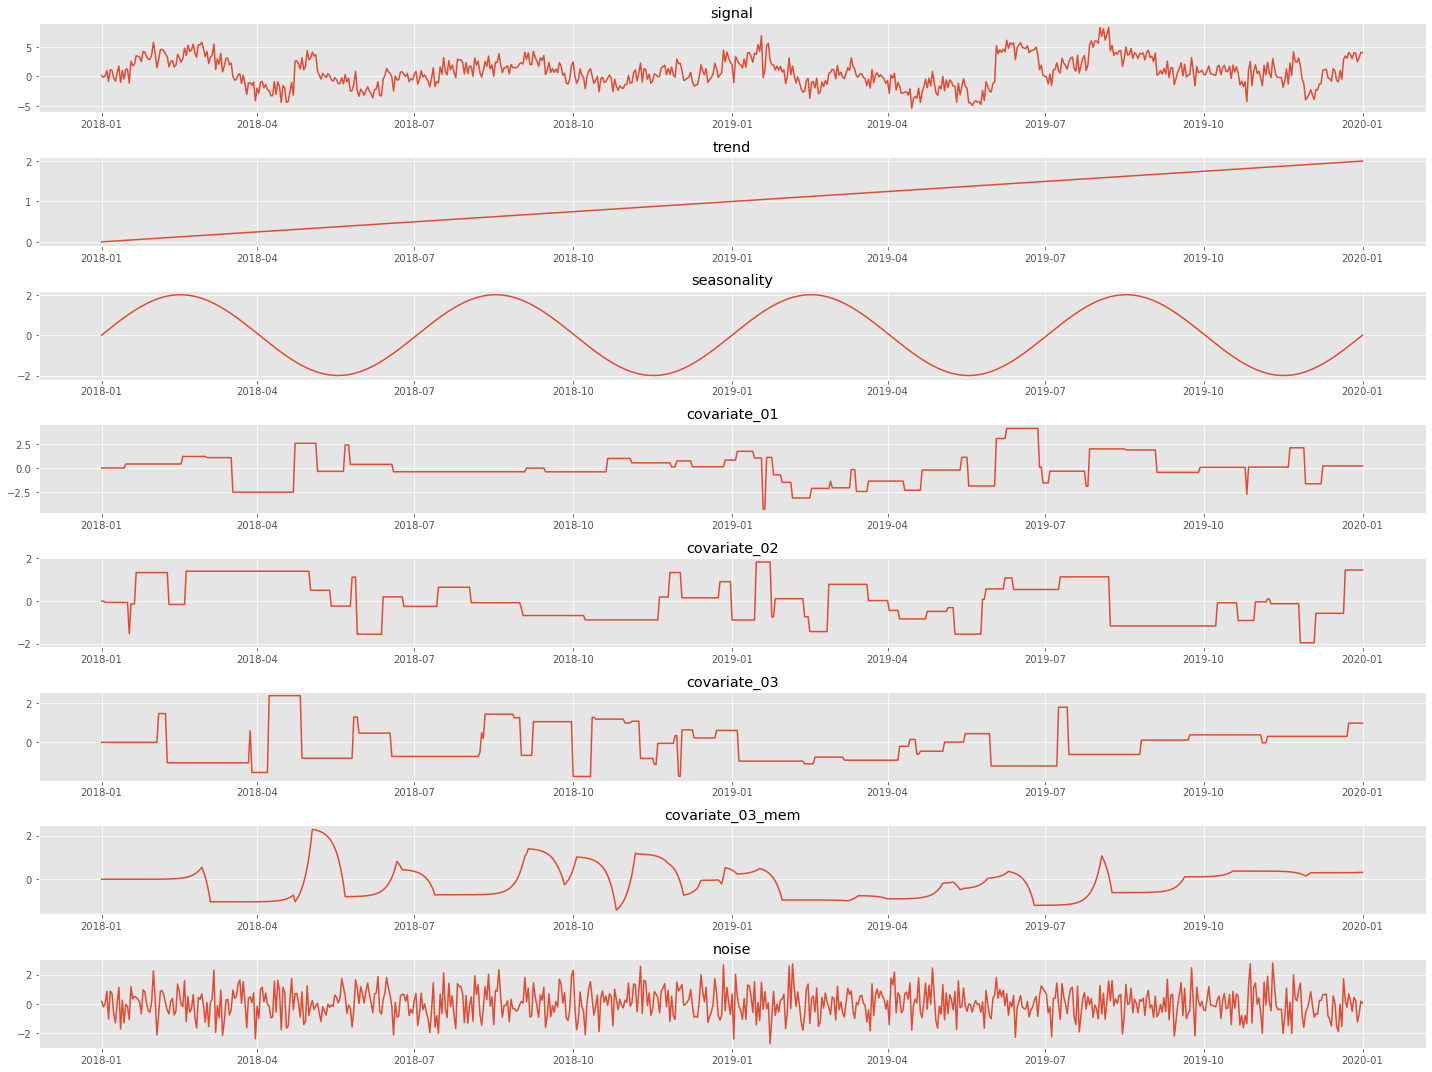

In [2]:
import numpy as np
import pandas as pd
import datetime
import collections
from matplotlib import pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
from scipy.ndimage import gaussian_filter

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()
    
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s
    
def create_signal():
    days_year = 365
    quaters_year = 4
    days_week = 7
    
    # two years of data, daily resolution
    idx = pd.date_range(start='2018-01-01', end='2020-01-01', freq='D') 

    df = pd.DataFrame(index=idx, dtype=float)
    df = df.fillna(0.0)
    
    n = len(df.index)
    trend = np.zeros(n)
    seasonality = np.zeros(n)
    for t in range(n):
        trend[t] = 2.0 * t/n
        seasonality[t] = 2.0 * np.sin(np.pi * t/days_year*quaters_year)
    
    covariate_01 = step_series(n, 0, 2.0, 50)
    covariate_02 = step_series(n, 0, 1.0, 50)
    covariate_03 = step_series(n, 0, 1.0, 50)
    
    mem_filter = np.exp(np.linspace(-10, 0, 50))
    covariate_03_mem = np.convolve(covariate_03, mem_filter/np.sum(mem_filter), mode='same')
    
    noise = np.random.randn(n)
    
    signal = trend + seasonality + covariate_01 + covariate_02 + covariate_03_mem + noise
    
    df['signal'], df['trend'], df['seasonality'] = signal, trend, seasonality
    df['covariate_01'], df['covariate_02'], df['covariate_03'] = covariate_01, covariate_02, covariate_03  
    df['covariate_03_mem'], df['noise'] = covariate_03_mem, noise 
    
    return df

df = create_signal()
fig, ax = plt.subplots(len(df.columns), figsize=(20, 15))
for i, c in enumerate(df.columns):
    ax[i].plot(df.index, df[c])
    ax[i].set_title(c)

plt.tight_layout()
plt.show()

## Step 2: Decompose the Signal Using BSTS Model

The second step is to decompose the signal. We build a BSTS model with the following components:
* Seasonal. We use 26 weeks (half a year) cycle.
* Trend. Local trend that can gradually change the slope according to AR(1) process.
* Covariates. Sparse linear regression for obvserved covariates.
* Covariates with memory effects. We estimate the contribution of covariates with memory effects uisng a linear regression over multiple shifted copies of the covariate - the linear combination of all copies is supposed to reproduce the shape of the unobserved (smoothed and delayed) version of the covariate.

We also compare two versions of model parameters:
* Default priors
* Customized priors:
   * We impose stronger correlation between adjacent seasons using MultivariateNormal distribution. Alternatively, one can use SmoothSeasonal which uses trigonometric terms in order to impose smoothness.
   * We impose a strong prior on the trend autocorrelation coeffecients to make it smooth (near-linear)
   
We visualize the trend, seasonal effect, without-memory and with-memory covariate effect. 
For without-memory covariates, we extract and visualize individual covariates from the linear regression.
For with-memory covariate, we shown the effect of all shifts in the regression combined becasue it reproduces the actual contribution of the covariate.

In [9]:
l

array([[0.37556939, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.35281492, 0.12874004, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.29249499, 0.22766721, 0.06055315, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.21400115, 0.26681184, 0.15140269, 0.03383105, 0.        ,
        0.        , 0.        , 0.        ],
       [0.13820693, 0.24553989, 0.22337316, 0.10634595, 0.02136221,
        0.        , 0.        , 0.        ],
       [0.07891166, 0.1869277 , 0.24331858, 0.184782  , 0.07960235,
        0.01408892, 0.        , 0.        ],
       [0.04029854, 0.11976754, 0.21224373, 0.22638014, 0.15872688,
        0.05889294, 0.01123212, 0.        ],
       [0.01992822, 0.06294796, 0.15650237, 0.21138828, 0.22109659,
        0.1258001 , 0.05260083, 0.00621097]])

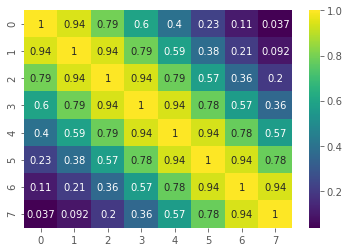

In [3]:
# Generate covariance matrix for MultivariateNormal distribution and visualize correlations for samples drawn from such a distribution.
# We use a 'blurred' diagonal matrix to impose correlation between adjacent seasons. 

def gauss_covariance_matrix(n, sigma):
    return gaussian_filter(np.eye(2*n), sigma=sigma, mode='wrap')[int(n/2):int(-n/2), int(n/2):int(-n/2)]

n = 8
m = gauss_covariance_matrix(n, 2.0)
l = np.linalg.cholesky(m) # 숄레스키 분해
# The multivariate normal distribution on R^k.
mvn = tfd.MultivariateNormalTriL(loc=np.zeros(n), scale_tril = np.linalg.cholesky(m) )

samples = mvn.sample(1000)
df = pd.DataFrame(samples, dtype=float)
sns.heatmap(df.corr(), cmap= "viridis", annot = True);

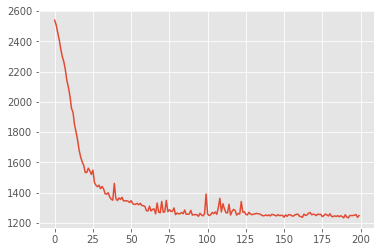

Inferred parameters:
observation_noise_scale: 0.9781069755554199 +- 0.020729653537273407
seasonal_effect/_drift_scale: 0.03675251826643944 +- 0.03731299564242363
trend_effect/_level_scale: 0.18787428736686707 +- 0.016936978325247765
trend_effect/_slope_mean: -0.009749343618750572 +- 0.006012341007590294
trend_effect/_slope_scale: 0.021944263949990273 +- 0.015606723725795746
trend_effect/_autoregressive_coef: 0.2828783094882965 +- 0.27722984552383423
covariate_effect/_global_scale_variance: 1.6196829080581665 +- 0.11735814064741135
covariate_effect/_global_scale_noncentered: 1.770984411239624 +- 0.052186429500579834
covariate_effect/_local_scale_variances: [1.790299  2.1740263 0.8579253] +- [0.20150521 0.16330796 0.61814576]
covariate_effect/_local_scales_noncentered: [1.6220353 1.695556  0.5216778] +- [0.05466678 0.0981041  0.30120754]
covariate_effect/_weights_noncentered: [ 1.8787771   1.7678505  -0.27324882] +- [0.05752163 0.11831921 0.5047306 ]
covariate_mem_effect/_weights: [-0.02

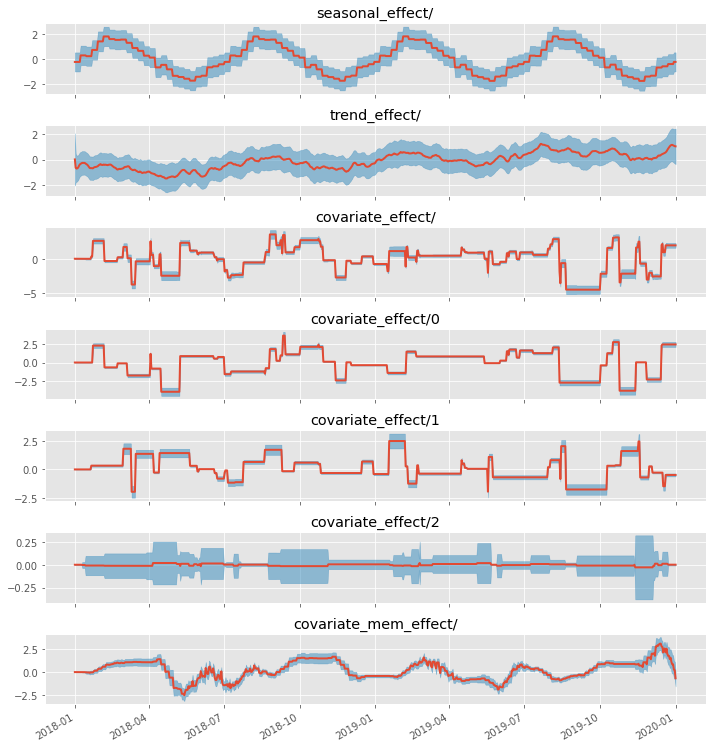

In [15]:
model_params = {}

model_params['default'] = {
    'n_seasons': 26,
    'seasonal:initial_effect_prior': None,
    'trend:slope_mean_prior': None,
    'trend:slope_scale_prior': None,
    'trend:level_scale_prior': None,
    'trend:autoregressive_coef_prior': None
}
model_params['custom'] = model_params['default'].copy()
model_params['custom'].update({
    
    'seasonal:initial_effect_prior': tfd.MultivariateNormalTriL(
            loc = np.zeros(26).astype(np.float32), 
            scale_tril = np.linalg.cholesky(gauss_covariance_matrix(26, 0.01)).astype(np.float32)),
    
    'trend:autoregressive_coef_prior': tfd.GeneralizedNormal(loc=1.0, scale=1e-4, power=4),
})

def build_sts_model(observed_signal, covariates, covariates_mem, params):
    
    seasonal_effect = sts.Seasonal(
        num_seasons=params['n_seasons'], 
        num_steps_per_season=7,
        allow_drift=True,
        initial_effect_prior=params['seasonal:initial_effect_prior'],
        observed_time_series=observed_signal,
        name='seasonal_effect')
    
    trend_effect = sts.SemiLocalLinearTrend(
        observed_time_series=observed_signal,
        constrain_ar_coef_positive=True,
        
        level_scale_prior=params['trend:level_scale_prior'],
        slope_mean_prior=params['trend:slope_mean_prior'],
        slope_scale_prior=params['trend:slope_scale_prior'],
        autoregressive_coef_prior=params['trend:autoregressive_coef_prior'],
        
        name='trend_effect')
    
    covariate_effect = sts.SparseLinearRegression(
                    design_matrix=covariates,
                    name=f'covariate_effect')
    
    covariate_mem_effect = sts.LinearRegression(
                    design_matrix=covariates_mem,
                    name=f'covariate_mem_effect')
    
    model = sts.Sum([seasonal_effect,
                     trend_effect,
                     covariate_effect,
                     covariate_mem_effect,
                    ], 
                    observed_time_series=observed_signal)
    return model

def fit_sts_model(model, signal):
    num_variational_steps = 200
    optimizer = tf.optimizers.Adam(learning_rate=.1)
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model = model)

    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model.joint_log_prob(observed_time_series=signal),
            surrogate_posterior=variational_posteriors,
            optimizer=optimizer,
            num_steps=num_variational_steps)
        
        return elbo_loss_curve

    elbo_loss_curve = train()
    
    return elbo_loss_curve, variational_posteriors


def component_effects(component_dists, parameter_samples):
    
    def regression_dist(regression_component, regression_params):
        regression_weights = regression_component.params_to_weights(*regression_params)  # shape [num_samples, num_features]
        sampled_effects = tf.einsum('ij,...j->...ij',                                    # shape [num_samples, num_timesteps, num_features]
                                  regression_component.design_matrix.to_dense(),
                                  regression_weights)
        effects_dist = tfd.Empirical(sampled_effects, event_ndims=2)
        
        return effects_dist
    
    means, stddevs = collections.OrderedDict(), collections.OrderedDict()
    for k, dist in component_dists.items():
        means[k.name] = dist.mean()
        stddevs[k.name] = dist.stddev()
        
        if isinstance(k, sts.SparseLinearRegression):
            params = {p_name:v for (p_name,v) in parameter_samples.items() if p_name.startswith(k.name)}
            features_dist = regression_dist(k, params.values())
            
            n = dist.event_shape[0]         
            
            for i, w in enumerate(tf.transpose(features_dist.mean())):
                means[f'{k.name}{i}'] = w
                
            for i, w in enumerate(tf.transpose(features_dist.stddev())):
                stddevs[f'{k.name}{i}'] = w
            
    return means, stddevs

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict):

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(10, 1.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        ax = fig.add_subplot(num_components,1,1+i)
        
        component_mean = component_means_dict[component_name]
        ax.plot(dates, component_mean, lw=2)
        
        if component_stddevs_dict is not None:
            component_stddev = component_stddevs_dict[component_name]
            ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
            
        ax.set_title(component_name)
        axes_dict[component_name] = ax
    
    fig.autofmt_xdate()
    fig.tight_layout()
    
    return fig, axes_dict


def evaluate_model(model, signal):
    
    elbo_loss_curve, variational_posteriors = fit_sts_model(model, signal)
    
    q_samples = variational_posteriors.sample(20)

    component_dists = sts.decompose_by_component(
        model,
        observed_time_series=signal,
        parameter_samples=q_samples)

    plt.plot(elbo_loss_curve)
    plt.show()

    print("Inferred parameters:")
    for param in model.parameters:
        print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples[param.name], axis=0),
                              np.std(q_samples[param.name], axis=0)))

    means, stddevs = component_effects(component_dists, q_samples)

    fig, ax = plot_components(df.index, means, stddevs)
    
    return fig, ax



def shift(a, n):
    if n == 0:
        return a
    return np.pad(a, ((n, 0)), 'constant', constant_values=(0, ))[:-n]

df = create_signal()

signal = df['signal'].values.astype(np.float32)
covariates = df[['covariate_01', 'covariate_02', 'covariate_03']].values.astype(np.float32)
c = df['covariate_03'].values.astype(np.float32)
covariate_mem = np.vstack([shift(c, n) for n in np.arange(0, 50, 5)]).T

model = build_sts_model(signal, covariates, covariate_mem, model_params['default'])
evaluate_model(model, signal)
plt.show()